In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_text
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [14]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [15]:
df.drop(columns=["date"], inplace=True)

In [16]:
#to lowercase
df['staff_experience'] = df['staff_experience'].astype(str).str.lower().str.strip()
df['staff_experience'] = df['staff_experience'].replace(['nan', 'none', 'NaN'], np.nan)
df['waste_category'] = df['waste_category'].astype(str).str.lower().str.strip()

# 이상치 처리
mode_temp = df['temperature_C'][(df['temperature_C'] > 0) & (df['temperature_C'] < 36)].mode()[0]
df.loc[(df['temperature_C'] <= 0) | (df['temperature_C'] >= 36), 'temperature_C'] = mode_temp

df = df[df['meals_served'] < 500]

# 수치형 결측치 처리
df['temperature_C'] = df['temperature_C'].fillna(mode_temp)
df['past_waste_kg'] = df['past_waste_kg'].fillna(df['past_waste_kg'].mean())

# experience 결측치 처리
df['staff_experience'] = df['staff_experience'].replace(['nan', 'None', 'NaN'], np.nan)
def fill_staff_experience(row):
    if pd.isnull(row['staff_experience']):
        staff = row['kitchen_staff']
        waste = row['past_waste_kg']

        if staff < 12 and waste > 20:
            return 'beginner'
        elif staff > 17 and waste < 15:
            return 'expert'
        else:
            return 'intermediate'
    return row['staff_experience']

df['staff_experience'] = df.apply(fill_staff_experience, axis=1)

experience_order = {
    'beginner': 0,
    'intermediate': 1,
    'expert': 2
}
df['staff_experience'] = df['staff_experience'].map(experience_order)

# waste_category Label 인코딩
label_encoders = {}
categorical_cols = ["waste_category"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [17]:
# 요인 별 clustering
env_features = ['temperature_C', 'humidity_percent']
ops_features = ['meals_served', 'special_event', 'day_of_week']
human_features = ['kitchen_staff', 'staff_experience']

In [18]:
# 정규화

# 요인 내 정규화 및 요인 score 계산
def normalize_group(df, features):  
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(df[features])
    return pd.DataFrame(normed, columns=features).mean(axis=1)


df['env_score'] = normalize_group(df, env_features)
df['ops_score'] = normalize_group(df, ops_features)
df['human_score'] = normalize_group(df, human_features)

# 요인 score 정규화
score_df = df[['env_score', 'ops_score', 'human_score']]
score_scaler = MinMaxScaler()
df[['env_score_norm', 'ops_score_norm', 'human_score_norm']] = score_scaler.fit_transform(score_df)

df = df.dropna(subset=[
    'env_score', 'ops_score', 'human_score',
    'env_score_norm', 'ops_score_norm', 'human_score_norm',
    'food_waste_kg'
])
df = df.copy()


cluster_input = df[['env_score_norm', 'ops_score_norm', 'human_score_norm']]

In [19]:
missing_values = df.isnull().sum()

print(missing_values)

ID                  0
meals_served        0
kitchen_staff       0
temperature_C       0
humidity_percent    0
day_of_week         0
special_event       0
past_waste_kg       0
staff_experience    0
waste_category      0
food_waste_kg       0
env_score           0
ops_score           0
human_score         0
env_score_norm      0
ops_score_norm      0
human_score_norm    0
dtype: int64


In [20]:
# 클러스터링
cluster_input = df[['env_score_norm', 'ops_score_norm', 'human_score_norm']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[cluster_input.columns])

predictors = env_features + ops_features + human_features
scaler = StandardScaler()
df[predictors] = scaler.fit_transform(df[predictors])

# 클러스터별 회귀분석
target = 'food_waste_kg'
predictors = env_features + ops_features + human_features

In [21]:
# 클러스터 평균 출력
cluster_mean = df.groupby('cluster')[['env_score_norm', 'ops_score_norm', 'human_score_norm']].mean()
print(cluster_mean)

# 클러스터별 회귀 분석 
for cid in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cid]
    X = cluster_data[predictors]
    y = cluster_data[target]

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    # 계수 출력
    coef_info = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_
    })

    # Permutation Importance
    result = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error', n_repeats=30, random_state=42)
    importances = result.importances_mean
    stds = result.importances_std

    importance_info = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': importances,
        'importance_std': stds
    }).sort_values(by='importance_mean', ascending=False)

    # 결과 출력
    print(f"\nCluster {cid} → Test MSE: {mse:.2f}, n={len(X)}")
    print(f"Cluster {cid} → R^2: {r2:.3f}")
    print(f"  - Coefficients:\n{coef_info.to_string(index=False)}")
    print(f"\n  - Permutation Importances:\n{importance_info.to_string(index=False)}")

    # 파일 저장 (선택)
    coef_info.to_csv(f'cluster_{cid}_coefficients.csv', index=False)
    importance_info.to_csv(f'cluster_{cid}_importances.csv', index=False)

         env_score_norm  ops_score_norm  human_score_norm
cluster                                                  
0              0.384877        0.398300          0.693982
1              0.713422        0.370555          0.485533
2              0.390668        0.324873          0.244258

Cluster 0 → Test MSE: 98.89, n=292
Cluster 0 → R^2: 0.192
  - Coefficients:
         feature  coefficient
   temperature_C     0.046313
humidity_percent     0.991787
    meals_served     6.082641
   special_event     2.846276
     day_of_week    -0.354591
   kitchen_staff     0.847450
staff_experience    -1.882789

  - Permutation Importances:
         feature  importance_mean  importance_std
    meals_served        78.647394       10.299091
   special_event        19.609034        3.629553
staff_experience         6.873266        2.471751
humidity_percent         1.844591        1.239534
   kitchen_staff         1.417217        0.884141
     day_of_week         0.162269        0.325496
   temperatur

In [22]:
df[df['cluster'] == 1].head()

,ID,meals_served,kitchen_staff,temperature_C,humidity_percent,day_of_week,special_event,past_waste_kg,staff_experience,waste_category,food_waste_kg,env_score,ops_score,human_score,env_score_norm,ops_score_norm,human_score_norm,cluster
0,0,-0.920244,0.242502,0.804870,-0.890100,-1.494604,-0.306251,7.740587,0.084355,0,28.946465,0.484621,0.080201,0.535714,0.489647,0.078098,0.535714,1
2,4,-1.341183,0.941652,0.781464,0.473580,-0.998319,-0.306251,41.184305,-1.371617,2,53.008323,0.679023,0.095656,0.392857,0.686126,0.093803,0.392857,1
4,6,-0.034519,-0.456648,0.600265,1.089394,-1.494604,-0.306251,26.525097,0.084355,2,44.156984,0.741925,0.164578,0.428571,0.749700,0.163837,0.428571,1
6,8,1.245835,0.941652,-0.277487,0.950458,-1.494604,-0.306251,22.862659,-1.371617,3,52.172118,0.593746,0.286550,0.392857,0.599938,0.287776,0.392857,1
9,11,-0.297606,-1.155799,0.469989,1.645853,-0.998319,-0.306251,23.067392,1.540328,1,33.233930,0.803644,0.195071,0.571429,0.812078,0.194822,0.571429,1


In [23]:
df.to_csv("clustered_output.csv", index=False)

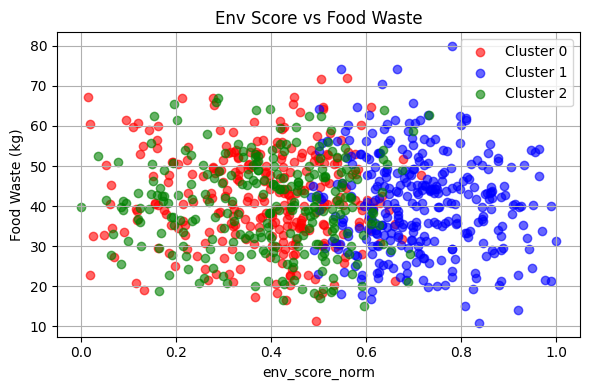

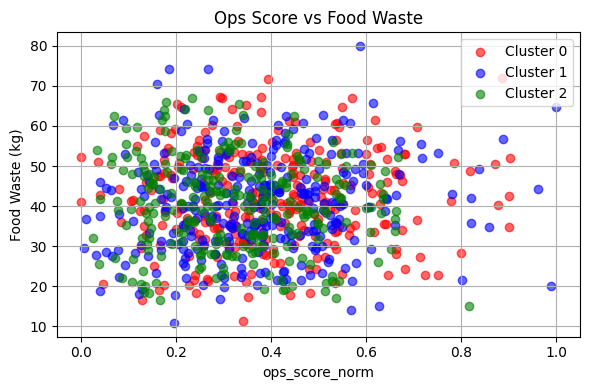

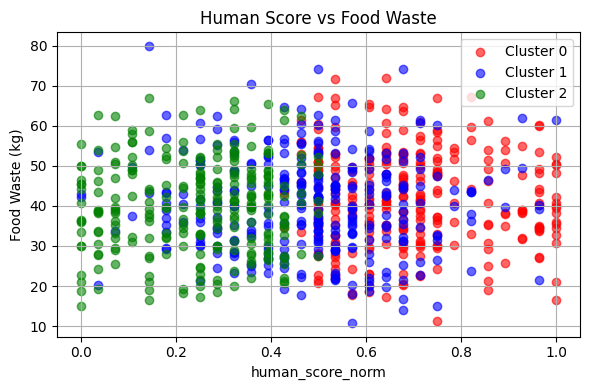

In [24]:
# 색상 세트 (클러스터별)
colors = ['red', 'blue', 'green']

# 1. 환경 점수
plt.figure(figsize=(6, 4))
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['env_score_norm'], cluster_data['food_waste_kg'],
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id}")
plt.title("Env Score vs Food Waste")
plt.xlabel("env_score_norm")
plt.ylabel("Food Waste (kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 운영 점수
plt.figure(figsize=(6, 4))
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['ops_score_norm'], cluster_data['food_waste_kg'],
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id}")
plt.title("Ops Score vs Food Waste")
plt.xlabel("ops_score_norm")
plt.ylabel("Food Waste (kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 인적 점수
plt.figure(figsize=(6, 4))
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['human_score_norm'], cluster_data['food_waste_kg'],
                color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id}")
plt.title("Human Score vs Food Waste")
plt.xlabel("human_score_norm")
plt.ylabel("Food Waste (kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()